In [ ]:
from google.colab import files
files.upload()

Saving pens.csv to pens.csv
Saving non_pen.csv to non_pen.csv
Saving data.csv to data.csv


{'data.csv': b',duration,distance,build_up_duration,shot_technique_3,shot_open_goal,pass_height_name,pass_cut_back,shot_technique_4,pass_through_ball,shot_technique_2,follows_goalkeeper,follows_dribble,pass_cross,goal\r\n0,1.979564,9.899494936611664,9.586011,0,0,-1,0,1,0,0,0,0,0,0\r\n1,0.0911,8.602325267042627,8.001138000000001,0,0,-1,0,1,0,0,0,0,0,0\r\n2,1.4563700000000002,25.709920264364875,7.802849,0,0,-1,0,1,0,0,0,0,0,0\r\n3,1.12,25.96150997149434,13.025000000000002,0,0,-1,0,1,0,0,0,0,0,0\r\n4,0.694403,14.7648230602334,10.572648,0,0,-1,0,0,0,1,0,0,0,0\r\n5,1.4268,26.87005768508881,0.0,0,0,-1,0,1,0,0,0,0,0,0\r\n6,1.452797,18.681541692269406,0.0,0,0,-1,0,1,0,0,0,0,0,0\r\n7,0.1262,5.830951894845301,0.5049,0,0,-1,0,1,0,0,0,0,0,0\r\n8,1.8476,32.2490309931942,2.538736,0,0,-1,0,0,0,1,0,0,0,0\r\n9,0.1387,16.76305461424021,22.790875,0,0,-1,0,1,0,0,0,0,0,0\r\n10,1.538,24.698178070456933,0.0,0,0,-1,0,1,0,0,0,0,0,0\r\n11,0.203,18.60107523773827,6.494999999999999,0,0,-1,0,0,0,1,0,0,0,0\r\n12,1.

In [ ]:
non_pen.head()

,duration,distance,build_up_duration,shot_technique_normal,shot_technique_lob,shot_technique_half_volley,shot_open_goal,pass_height_name,pass_cut_back,pass_through_ball,follows_goalkeeper,follows_dribble,pass_cross,goal,player_name,team_name,match_id,x_loc,y_loc,pass_player_name
id,,,,,,,,,,,,,,,,,,,,
aabcd43f-68ca-45f6-9d84-e97cb858a940,1.979564,9.899495,9.586011,1,0,0,0,-1,0,0,0,0,0,0,Gilly Louise Scarlett Flaherty,West Ham United LFC,19777,113.0,33.0,NaN
0e6703a6-fe2a-4f0b-864c-1f85068c9b74,0.091100,8.602325,8.001138,1,0,0,0,-1,0,0,0,0,0,0,Jane Ross,West Ham United LFC,19724,113.0,45.0,NaN
a93acb2a-3fd7-4fb9-aa0b-a8c2337cdbac,1.456370,25.709920,7.802849,1,0,0,0,-1,0,0,0,0,0,0,Brooke Chaplen,Reading WFC,19732,95.0,46.0,NaN
701abd4b-93b0-4579-904f-bd8d5f40cf3b,1.120000,25.961510,13.025000,1,0,0,0,-1,0,0,0,0,0,0,Denise O'Sullivan,North Carolina Courage,7456,95.0,47.0,NaN
534f07ec-fb85-4f85-8ad0-a4596a4c04e3,0.694403,14.764823,10.572648,0,0,1,0,-1,0,0,0,0,0,0,Bethany Mead,Arsenal WFC,19797,107.0,33.0,NaN


In [ ]:
pens.head()

,duration,distance,build_up_duration,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_open_goal,pass_height_name,pass_cut_back,pass_through_ball,follows_goalkeeper,follows_dribble,pass_cross,goal,player_name,team_name,match_id,x_loc,y_loc,pass_player_name,xg,xa
id,,,,,,,,,,,,,,,,,,,,,,
9b9bb894-d06c-4daf-8614-a358ca76babc,0.562500,12.000000,0.0,0,0,1,NaN,NaN,NaN,NaN,0,0,NaN,1,Kim Little,Arsenal WFC,19736,108.0,40.0,NaN,0.769231,0
cbc26d7c-fefd-40de-8ed1-1cd1020e0a66,0.693000,11.045361,0.0,0,0,1,NaN,NaN,NaN,NaN,0,0,NaN,1,Lynn Williams,North Carolina Courage,7519,109.0,41.0,NaN,0.769231,0
da094db6-8d51-49fa-869e-5f5e812061b6,1.419222,12.000000,0.0,0,0,1,NaN,NaN,NaN,NaN,0,0,NaN,1,Fara Williams,Reading WFC,19801,108.0,40.0,NaN,0.769231,0
df424fcd-8d62-4ac9-a6a0-842bc8094a16,0.808600,11.045361,0.0,0,0,1,NaN,NaN,NaN,NaN,0,0,NaN,1,Kim Little,Arsenal WFC,19797,109.0,41.0,NaN,0.769231,0
e7eac19d-09b2-468f-b45a-68c21798e706,0.627100,12.000000,0.0,0,0,1,NaN,NaN,NaN,NaN,0,0,NaN,1,Lauren Bruton,Reading WFC,19716,108.0,40.0,NaN,0.769231,0


In [ ]:
data.tail()

,duration,distance,build_up_duration,shot_technique_3,shot_open_goal,pass_height_name,pass_cut_back,shot_technique_4,pass_through_ball,shot_technique_2,follows_goalkeeper,follows_dribble,pass_cross,goal
3096,0.852495,12.083046,6.985500,0,0,0,1,1,0,0,0,0,1,0
3097,1.596917,6.708204,2.006800,0,0,1,0,1,0,0,0,0,0,0
3098,0.735500,9.219544,3.066991,0,0,1,0,1,0,0,0,0,0,0
3099,0.400000,17.804494,9.533000,0,0,1,0,1,0,0,0,0,0,0
3100,1.053000,17.204651,8.880000,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from collections import OrderedDict
from imblearn.under_sampling import TomekLinks

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data = pd.read_csv('data.csv', index_col=0)
X = data.drop('goal', axis=1)
y = data['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)

In [ ]:
def plot_loss(model_list, min_estimators=10, max_estimators=200):
    loss_rate = OrderedDict((clf_name, []) for clf_name, _ in model_list)

    min_estimators = min_estimators
    max_estimators = max_estimators

    for clf_name, clf in model_list:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)
            brier = brier_score_loss(y_test, y_pred_proba[:,1])
            loss_rate[clf_name].append((i, brier))
    
    plt.figure(figsize=(12,8))
    
    for clf_name, clf_err in loss_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=clf_name)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("Brier loss")
    plt.legend(loc="upper right");
    return

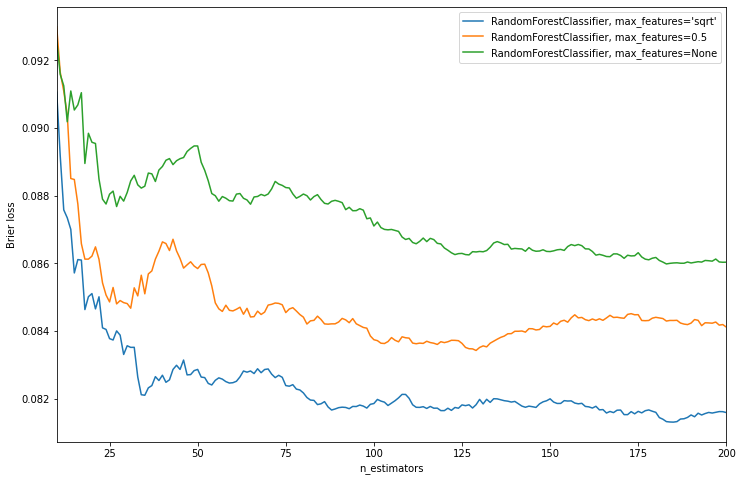

In [ ]:
max_features = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features='sqrt', random_state=42)),
    ("RandomForestClassifier, max_features=0.5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=0.5, random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=None, random_state=42)),
]

# Note that 'log2' is another commonly used value of max_features, but in this case it's essentially the same as 'sqrt'
plot_loss(max_features)

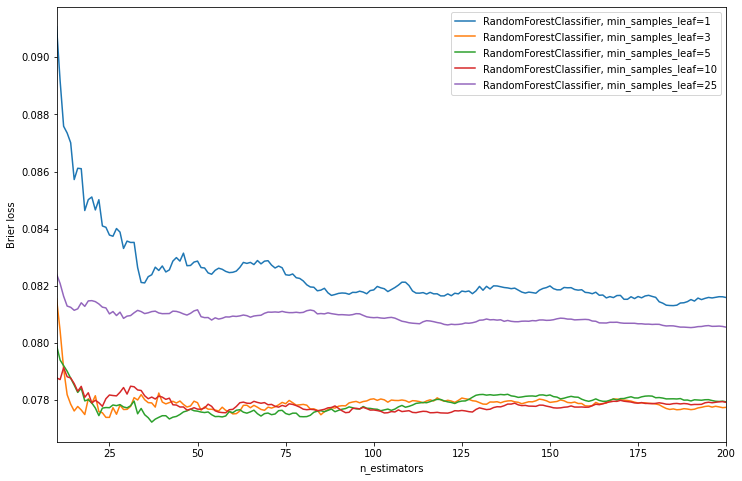

In [ ]:
min_leaf = [
    ("RandomForestClassifier, min_samples_leaf=1",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=1, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=3, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=5, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=10",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=10, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=25",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=25, random_state=42)),
]

plot_loss(min_leaf)

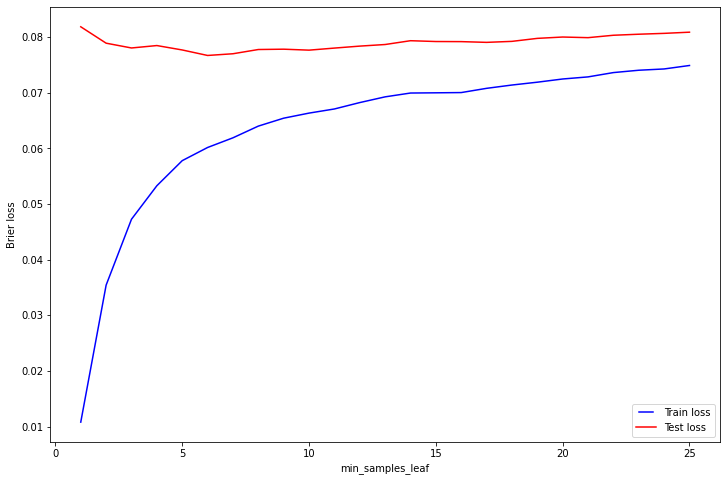

In [ ]:
min_leaf = [int(x) for x in np.linspace(start=1, stop=25, num=25)]
train_results = []
test_results = []
for leaf in min_leaf:
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=leaf, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(min_leaf, train_results, 'b', label='Train loss')
line2, = plt.plot(min_leaf, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('min_samples_leaf');

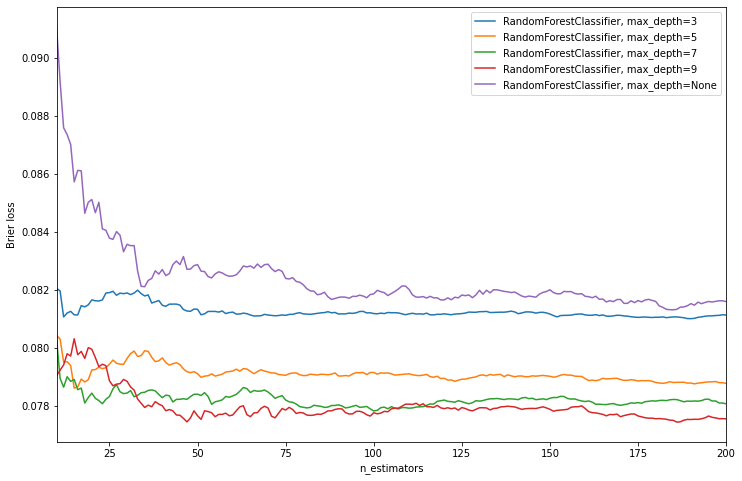

In [ ]:
max_depth = [
    ("RandomForestClassifier, max_depth=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=3, random_state=42)),
    ("RandomForestClassifier, max_depth=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=5, random_state=42)),
    ("RandomForestClassifier, max_depth=7",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=7, random_state=42)),
    ("RandomForestClassifier, max_depth=9",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=9, random_state=42)),
    ("RandomForestClassifier, max_depth=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=None, random_state=42)),
]

plot_loss(max_depth)

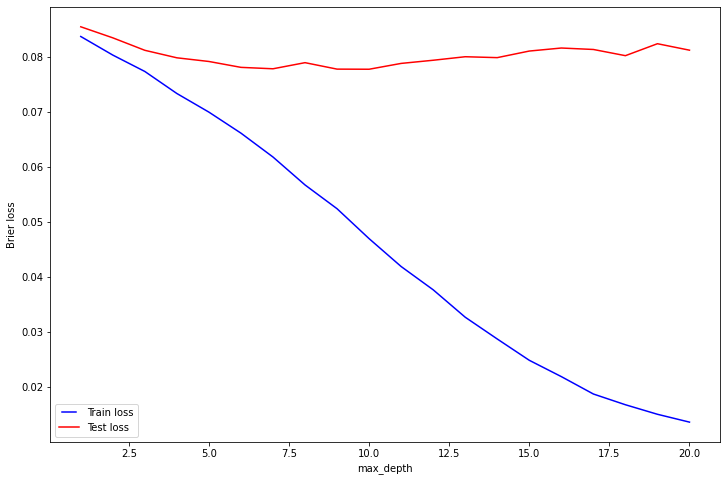

In [ ]:
max_depths = np.linspace(1, 20, 20, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(max_depths, train_results, 'b', label='Train loss')
line2, = plt.plot(max_depths, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('max_depth');

In [ ]:
m = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='sqrt', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.07896


In [ ]:
params = {
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'max_depth': [7, 8, 9, 10, 11]
}

gs = GridSearchCV(estimator=m, param_grid=params, cv=cv, n_jobs=-1,
                  scoring='brier_score_loss', return_train_score=True)

gs.fit(X_train, y_train)

def print_gs_results(gs, print_all=True):
    if print_all == True:
        print('Grid scores:')
        means = gs.cv_results_['mean_test_score']*-1
        stds = gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean, std * 2, params))
        print()
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    else:
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    return

print_gs_results(gs=gs)

Grid scores:
0.07573 (+/-0.00342) for {'max_depth': 7, 'min_samples_leaf': 3}
0.07602 (+/-0.00306) for {'max_depth': 7, 'min_samples_leaf': 4}
0.07614 (+/-0.00314) for {'max_depth': 7, 'min_samples_leaf': 5}
0.07608 (+/-0.00363) for {'max_depth': 7, 'min_samples_leaf': 6}
0.07619 (+/-0.00344) for {'max_depth': 7, 'min_samples_leaf': 7}
0.07544 (+/-0.00326) for {'max_depth': 8, 'min_samples_leaf': 3}
0.07547 (+/-0.00384) for {'max_depth': 8, 'min_samples_leaf': 4}
0.07574 (+/-0.00328) for {'max_depth': 8, 'min_samples_leaf': 5}
0.07608 (+/-0.00320) for {'max_depth': 8, 'min_samples_leaf': 6}
0.07608 (+/-0.00341) for {'max_depth': 8, 'min_samples_leaf': 7}
0.07511 (+/-0.00303) for {'max_depth': 9, 'min_samples_leaf': 3}
0.07537 (+/-0.00344) for {'max_depth': 9, 'min_samples_leaf': 4}
0.07576 (+/-0.00281) for {'max_depth': 9, 'min_samples_leaf': 5}
0.07590 (+/-0.00338) for {'max_depth': 9, 'min_samples_leaf': 6}
0.07577 (+/-0.00355) for {'max_depth': 9, 'min_samples_leaf': 7}
0.07504 (+/-

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.07701


In [ ]:
params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=9)],
    'max_depth': [i for i in range(3, 10)],
    'min_child_weight': [i for i in range(1, 7)],
    'subsample': [i/10.0 for i in range(6,11)],
    'colsample_bytree': [i/10.0 for i in range(6,11)]
}

rgs = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=20, cv=cv, random_state=42, n_jobs=-1,
                         scoring='brier_score_loss', return_train_score=True)
rgs.fit(X_train, y_train)
print_gs_results(gs=rgs, print_all=False)

Best: 0.07643 using {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


In [ ]:
def print_results(rf, xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

    print('Actual goals:', sum(y_test))
    print('Predicted goals (rf):', '{0:.2f}'.format(sum(y_pred_proba_rf)))
    print('Predicted goals (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (rf):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_rf)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))
    return

best_rf = gs.best_estimator_
best_xgb = rgs.best_estimator_

print_results(rf=best_rf, xgb=best_xgb)

Actual goals: 61
Predicted goals (rf): 61.05
Predicted goals (xgb): 62.68
Brier loss (rf): 0.07775
Brier loss (xgb): 0.07766


In [ ]:
calibrated_rf = CalibratedClassifierCV(gs.best_estimator_, cv=cv, method='sigmoid')
calibrated_xgb = CalibratedClassifierCV(rgs.best_estimator_, cv=cv, method='sigmoid')

print_results(rf=calibrated_rf, xgb=calibrated_xgb)

Actual goals: 61
Predicted goals (rf): 62.07
Predicted goals (xgb): 61.46
Brier loss (rf): 0.07843
Brier loss (xgb): 0.07893


In [ ]:
tomek = TomekLinks(n_jobs=-1, random_state=42)
X_train_res, y_train_res = tomek.fit_resample(X_train, y_train)

print('UNCALIBRATED')
print_results(rf=best_rf, xgb=best_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)
print('\nCALIBRATED')
print_results(rf=calibrated_rf, xgb=calibrated_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)

UNCALIBRATED


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Actual goals: 61
Predicted goals (rf): 67.13
Predicted goals (xgb): 66.98
Brier loss (rf): 0.07856
Brier loss (xgb): 0.07793

CALIBRATED
Actual goals: 61
Predicted goals (rf): 66.02
Predicted goals (xgb): 64.44
Brier loss (rf): 0.07925
Brier loss (xgb): 0.07896


In [ ]:
import pickle
filename = 'final_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

In [ ]:
non_pen = pd.read_csv('non_pen.csv', index_col=0)
pens = pd.read_csv('pens.csv', index_col=0)

X_new = non_pen.drop('goal', axis=1)
y_new = non_pen['goal']

extra_cols = ['player_name', 'team_name', 'match_id', 'x_loc', 'y_loc', 'pass_player_name']
extras = X_new[extra_cols]
X_new= X_new.drop(extra_cols, axis=1)

model.fit(X_new, y_new)

xg_df = X_new.copy()
xg_df['goal'] = y_new
xg_df['xg'] = model.predict_proba(X_new)[:,1]
xg_df['xa'] = np.where(xg_df['xg'].isna(), 0, xg_df['xg'])
xg_df = xg_df.merge(extras, left_index=True, right_index=True)
xg_df = xg_df.append(pens, sort=True)

xg_df['x_loc_m'] = xg_df['x_loc'] / 120 * 104
xg_df['y_loc_m'] = xg_df['y_loc'] / 80 * 68

In [ ]:
def draw_pitch(pitch, line, orientation, view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(69,105)
            plt.ylim(-1,69)
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') 
    
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)

        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(69,105)
            plt.xlim(-1,69)
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') 

        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)

        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        return

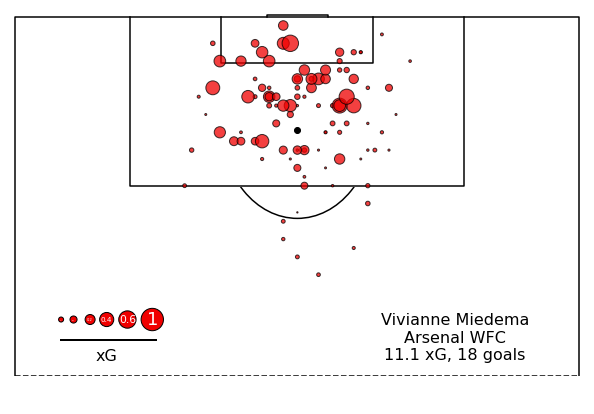

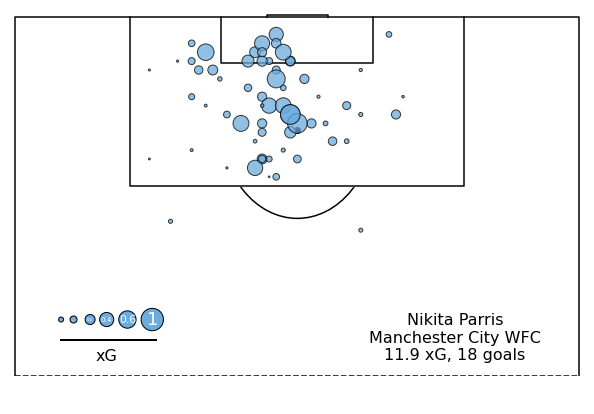

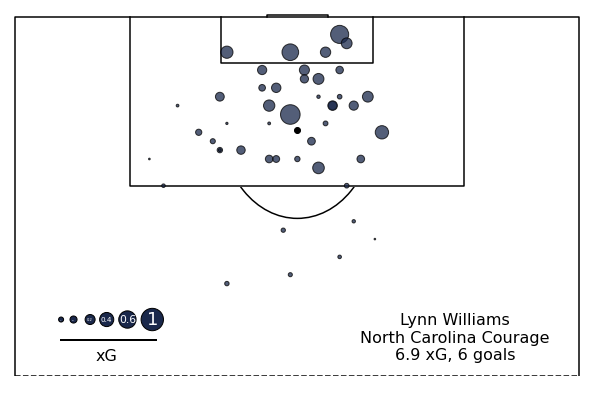

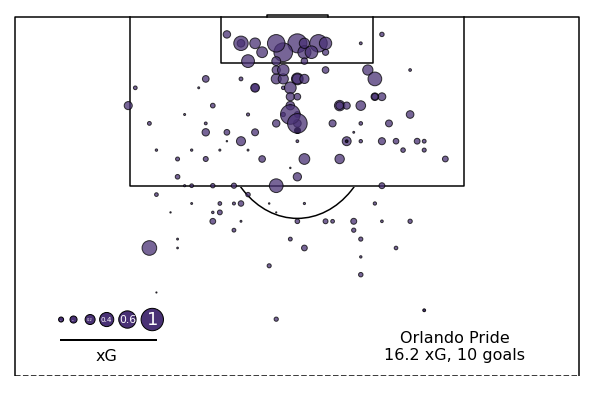

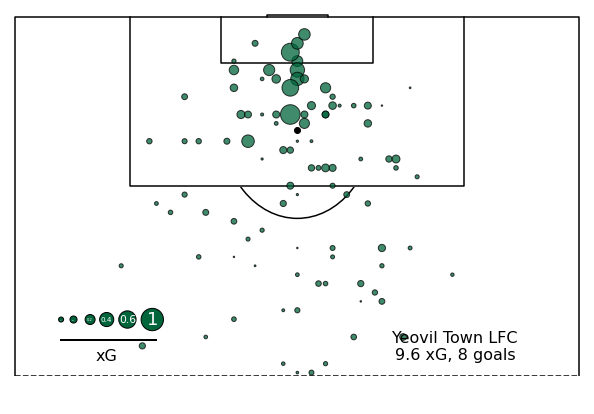

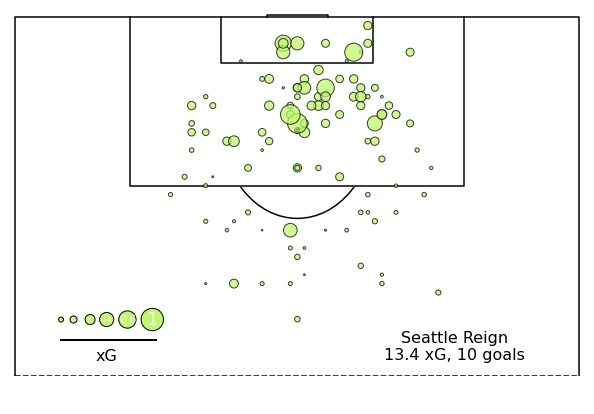

In [ ]:
def xg_plot(df, team_name, player_name=None, pitch_colour='#ffffff', line_colour='#000000', marker_colour='default'):
    
    draw_pitch(pitch_colour, line_colour, orientation='vertical', view='third')

    if player_name is not None:
        df = df[df['player_name'] == player_name]
        df = df[df['team_name'] == team_name]
    else:
        player_name=''
        df = df[df['team_name'] == team_name]
        
    markers = {'West Ham United LFC': '#7D2B3A', 'Reading WFC': '#004494', 'North Carolina Courage': '#1A284B',
               'Arsenal WFC': '#F00000', 'Chelsea LFC': '#001489', 'Bristol City WFC': '#DB0008',
               'Brighton & Hove Albion WFC': '#0054A6', 'Manchester City WFC': '#6CABDD', 'Washington Spirit': '#B02534',
               'Portland Thorns': '#561416', 'Utah Royals': '#022B52', 'Sky Blue FC': '#0C1963',
               'Birmingham City WFC': '#11437E', 'Liverpool WFC': '#E31B23', 'Chicago Red Stars': '#41B6E6',
               'Everton LFC': '#00369C', 'Orlando Pride': '#493175', 'Seattle Reign': '#C0F76D',
               'Houston Dash': '#E03F28', 'Yeovil Town LFC': '#00653B'}
    
    if marker_colour == 'default':
        marker_colour = markers.get(team_name)
    else: pass


    x_loc = df['x_loc_m']
    y_loc = [68 - i for i in df['y_loc_m']] 
    xg = [500 * i for i in df['xg']] 
    zo = 12 
    
    plt.scatter(y_loc, x_loc, s=xg, c=marker_colour, edgecolors='k', zorder=zo, alpha=0.75)

    mSize = [0.05,0.10,0.2,0.4,0.6,1] 
    mSizeS = [500 * i for i in mSize]
    mx = [5.5,7,9,11,13.5,16.5]
    my = [74.5,74.5,74.5,74.5,74.5,74.5]
    plt.scatter(mx, my, s=mSizeS, facecolors=marker_colour, edgecolor='k', zorder=zo)
    plt.plot([5.5,17], [72.5,72.5], color=line_colour, lw=2, zorder=zo)
    i = 0
    for i in range(len(mx)):
        plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color=pitch_colour, zorder=zo, ha='center', va='center')
    plt.text(11, 71,'xG', color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)

    xg_sum = str(round(np.sum(df['xg']), 1))
    goal_sum = str(np.sum(df['goal']))
    legend_string = player_name + '\n' + team_name + '\n' + xg_sum + ' xG, ' + goal_sum + ' goals'
    plt.text(53, 72.75, legend_string, color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)
    
    plt.text(0, 66, ' ' ,color=line_colour, ha='left', va='bottom', zorder=zo, fontsize=16);
    return

xg_plot(df=xg_df, team_name='Arsenal WFC', player_name='Vivianne Miedema')
xg_plot(df=xg_df, team_name='Manchester City WFC', player_name='Nikita Parris')
xg_plot(df=xg_df, team_name='North Carolina Courage', player_name='Lynn Williams')

xg_plot(df=xg_df, team_name='Orlando Pride')
xg_plot(df=xg_df, team_name='Yeovil Town LFC')
xg_plot(df=xg_df, team_name='Seattle Reign')

